In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Simple GPT example

In [2]:
import sys, os
root = os.path.join(os.getcwd(), '../')

sys.path.append(root)

INPUT_FILE = os.path.join(root,'templates/dcgun/gpt.in')


from gpt import GPT

In [3]:
G = GPT(input_file=INPUT_FILE, verbose=True)

Configured to run in /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpphhzy6rt


In [4]:
# Available variables
G.input['variables']

{'data_dump': 0.0,
 'Master_RF': 1300000000.0,
 'MTE': 120.0,
 'gun_voltage': 300.0,
 'sol_1_current': 3.32107,
 'auto_phase': 0.0,
 'single_particle': 0.0,
 'space_charge': 1.0,
 'space_charge_type': 1.0,
 'viewscreens_on': 1.0,
 'kill_backwards_particles': 1.0,
 'optimize_on': 0.0,
 'xoffset': 0.0,
 'yoffset': 0.0,
 'RadiusMax': 0.04,
 'GBacc': 5.5,
 'xacc': 6.5,
 'dtmin': 1e-16,
 'dtmax': 1e-10,
 'ZSLA01': 0.344,
 'ZCTB01': 0.746,
 'ZSLA02': 1.16,
 'Zdcgun': 0.15,
 'Maxdcgun': 500.0,
 'SLAPolarity': -1.0,
 'LSLA01': 0.6,
 'XSLA01': 0.0,
 'YSLA01': 0.0,
 'THXSLA01': 0.0,
 'IA1SDR01_z': 0.922,
 'ZSTOP': 1.5,
 'Alpha': 1.0,
 'Fn': 0.5,
 'verror': 0.005,
 'Nstd': 5.0,
 'tree_code_theta': 1.0,
 'tree_code_R': 1e-06,
 'Ntout': 50.0,
 'tmax': 1e-08,
 'ZSTART': -0.005}

In [5]:
# Set some of these
G.set_variables({'gun_voltage':375,'sol_1_current':-3})

In [6]:
# Run
G.run()

init dir:  /Users/chrisonian/Code/GitHub/lume-gpt/examples
running GPT in /private/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpphhzy6rt

General Particle Tracer - Oct 28 2014


In [7]:
# Ouput
G.output.keys()

dict_keys(['particles', 'start_time', 'run_time', 'run_error'])

In [8]:
# Raw screens
len(G.screen)

1

In [9]:
# Raw touts 
len(G.tout)

32

In [10]:
# Info
print(G)

GPT object:
   Original input file: gpt.in
   Use temp directory: True
   Work directory: None

Run Control
   Run configured: True
   Using temp directory: False
   Finished: True

Results
   Timeout occured: None
   Error occured: False
   Log: ['Warning: unknown option - -o\n', 'Warning: unknown option --o\n', '\n', 'General Particle Tracer - Oct 28 2014\n']



In [11]:
# Unique fingerprint based on input
G.fingerprint()

'204b984ebe4043ebaa04786333b5520a'

# Particle stats

In [12]:
# Some statistic that can be calculated on the particles
G.stat('norm_emit_x')

array([1.74030520e-06, 5.05909040e-06, 9.42959863e-06, 4.14775510e-06,
       4.45535914e-06, 4.78537885e-06, 6.04877283e-06, 1.37250961e-05,
       2.36687039e-05, 1.35630072e-05, 6.72500649e-06, 5.54286370e-06,
       5.33795109e-06, 5.28033365e-06, 5.26623428e-06, 5.28496931e-06,
       5.31665694e-06, 5.35511987e-06, 5.39594978e-06, 5.43613618e-06,
       5.47522119e-06, 5.51203764e-06, 5.54623121e-06, 5.57758646e-06,
       5.60675337e-06, 5.63374633e-06, 5.65841850e-06, 5.68083102e-06,
       5.70121776e-06, 5.71991618e-06, 5.73705441e-06, 5.75273072e-06])

In [13]:
# The units
G.stat_units('norm_emit_x')

'm*rad'

# Plot Statistics

In [14]:
from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (12,10)

Text(0, 0.5, 'norm_emit_x (m*rad)')

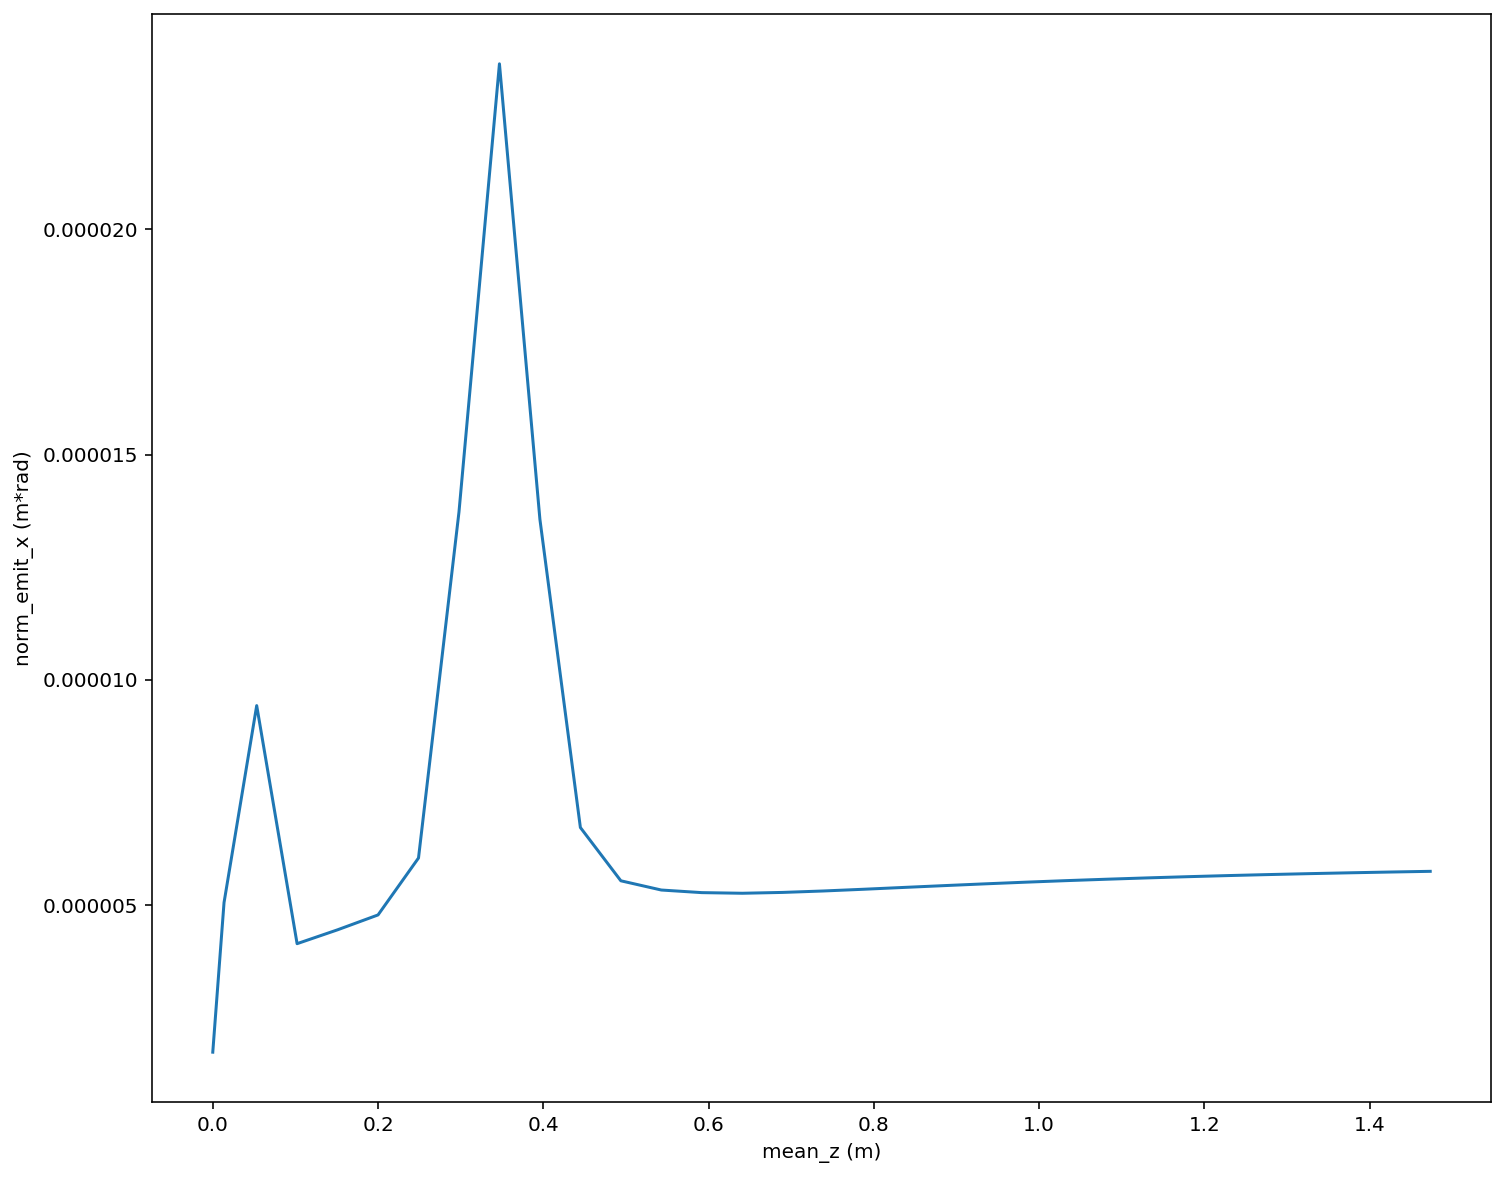

In [15]:
key1 = 'mean_z'
key2 = 'norm_emit_x'
dat1 = G.stat(key1)
dat2 = G.stat(key2)
units1 = G.stat_units(key1)
units2 = G.stat_units(key2)

fig, ax = plt.subplots()
ax.plot(dat1, dat2)
ax.set_xlabel(key1+f' ({units1})')
ax.set_ylabel(key2+f' ({units2})')

# Particle Densities

In [16]:
from pmd_beamphysics.plot import marginal_plot

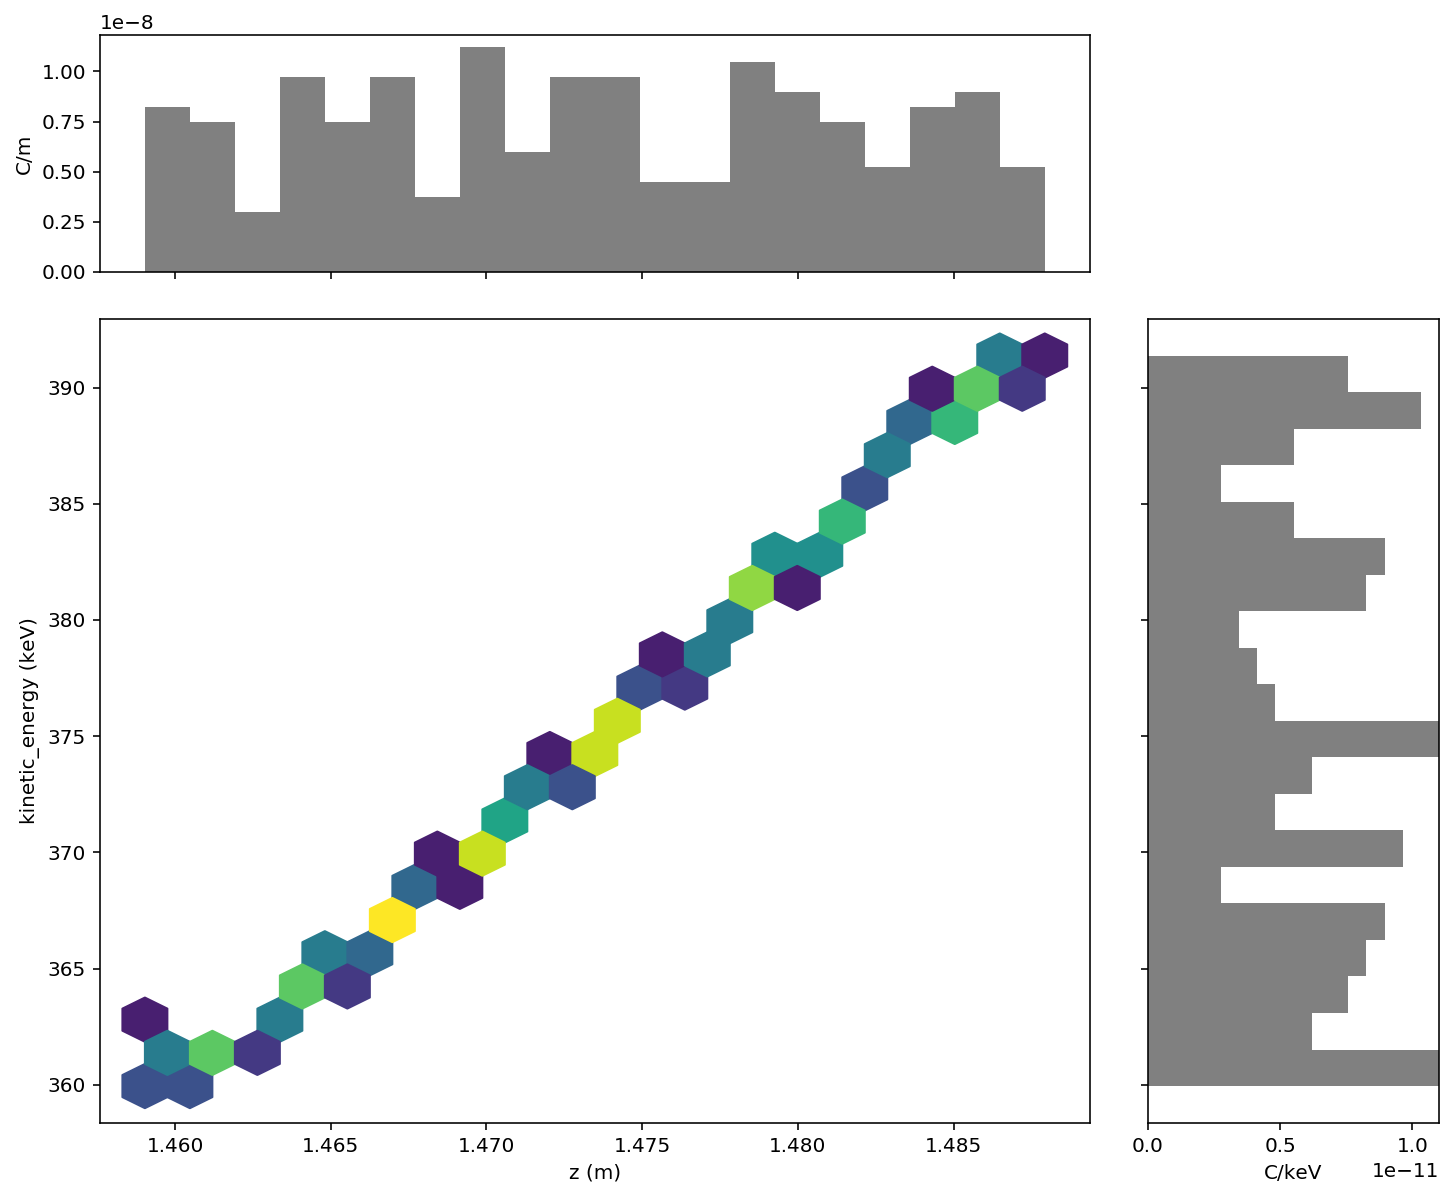

In [17]:
P = G.output['particles'][-1]

marginal_plot(P, 'z', 'kinetic_energy', bins=20)